# Introdução à Ciência de Dados - Trabalho Módulo 1

## Criando um dataset de carros usados coletados a partir da OLX

### Sumário

1. [Objetivo](#Objetivo)
2. [Importações das bibliotecas necessárias e definição de constantes globais](#Importações-da-bibliotecas-necessárias-e-definição-de-constantes-globais)
3. [Extração das urls dos carros de cada página da OLX](#Extração-das-urls-dos-carros-de-cada-página-da-OLX)
4. [Extraindo as informações de cada carro a partir das urls](#Extraindo-as-informações-de-cada-carro-a-partir-das-urls)
    - [Usando um único processo](#Abordagem-Single-Thread)
    - [Usando múltiplos processo (cerca de 10x mais rápido)](#Abordagem-Multithread)
5. [Agrupando as informações de múltiplos CSVs](#Agrupando-as-informações-de-múltiplos-CSVs)
6. [Limpando o dataset](#Limpando-o-dataset)

## Objetivo


Este trabalho propõe-se a criar um dataset de carros usados utilizando informações públicas disponíveis na plataforma da OLX.

## Importações da bibliotecas necessárias e definição de constantes globais

In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import os
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
HEADERS = {
        'authority': 'olx.com.br',
        'method': 'GET',
        'scheme': 'https',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-user': '?1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)'
}

## Extração das urls dos carros de cada página da OLX

### Coleta  dos links

In [3]:
def get_number_pages(base_url):
    response = requests.get(url=base_url, headers=HEADERS)
    soup = BeautifulSoup(response.content, 'lxml')
    results = soup.findAll('span', {'class': 'sc-1mi5vq6-0 eDXljX sc-ifAKCX fhJlIo'})

    ITEMS_PER_PAGE = 50
    n_cars_found = float(results[0].contents[0].split('de ')[-1].split(' ')[0].replace('.', ''))
    
    return min(int(n_cars_found/ITEMS_PER_PAGE), 100)

In [4]:
def collect_links(state):
    base_url = f'https://{state}.olx.com.br/autos-e-pecas/carros-vans-e-utilitarios'
    
    n_pages = get_number_pages(base_url)

    for page in range(n_pages-1):
        
        url = f'{base_url}?o={page+1}'
        response = requests.get(url=url, headers=HEADERS)
        
        soup = BeautifulSoup(response.content, 'lxml')
        items = soup.find_all('li', {'class': 'sc-1fcmfeb-2 juiJqh'})
        
        output_folder = 'links'
        
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        for item in items:
            try:
                with open(f'{output_folder}/{state}.txt', 'a') as outfile:
                    link = item.findAll('a')[0]['href']+'\n'
                    outfile.write(link)
            except IndexError:
                continue
        
    return 0                

In [ ]:
links_file = 'links.txt'

states = ['ac', 'al', 'ap', 'am', 'ba', 'ce', 'df', 'es', 'go', 'ma', 'mt', 'mg', 'ms', 'pa', 
          'pb', 'pr', 'pe', 'pi', 'rj', 'rn', 'rs', 'ro', 'rr', 'sc', 'sp', 'se', 'to']

if not os.path.exists(links_file):    
    pool = Pool(10)
    for link in tqdm(pool.imap_unordered(collect_links, states), total=len(states)):
        continue

    pool.terminate()
    pool.join()

 89%|████████▉ | 24/27 [07:41<01:27, 29.01s/it]

### Combinação dos links de todos os estados em um só txt

In [28]:
import glob

if not os.path.exists(links_file):
    files = glob.glob(os.path.join('links', '*.txt'))
    print(files)
    urls = []
    for file in files:
        with open(file, 'r') as infile:
            urls += infile.read()
    
    urls = ''.join(urls)
    
    with open('links.txt', 'w') as outfile:
        outfile.write(urls)

['links/sc.txt', 'links/sp.txt', 'links/es.txt', 'links/mt.txt', 'links/ce.txt', 'links/ro.txt', 'links/ap.txt', 'links/rn.txt', 'links/pb.txt', 'links/am.txt', 'links/rr.txt', 'links/rj.txt', 'links/ac.txt', 'links/se.txt', 'links/ma.txt', 'links/to.txt', 'links/go.txt', 'links/mg.txt', 'links/ba.txt', 'links/rs.txt', 'links/pa.txt', 'links/pr.txt', 'links/pe.txt', 'links/al.txt', 'links/df.txt', 'links/pi.txt', 'links/ms.txt']


## Extraindo as informações de cada carro a partir das urls

In [5]:
def extract_car_info(link):
    response = requests.get(url=link, headers=HEADERS)
    soup = BeautifulSoup(response.content, 'lxml')

    items = soup.find_all('div', {'class': 'sc-hmzhuo eNZSNe sc-jTzLTM iwtnNi'})

    car = {}
    # Caracteristics
    for item in items:
        title = item.find_all('span', {'class': 'sc-ifAKCX dCObfG'})[0].contents[0]
        try:
            value = item.find_all('span', {'class': 'sc-ifAKCX cmFKIN'})[0].contents[0]
        except:
            value = item.find_all('a', {'class': 'sc-57pm5w-0 XtcoW'})[0].contents[0]

        car[title] = value

    locations = soup.find_all('div', {'class': 'sc-hmzhuo sc-1f2ug0x-3 ONRJp sc-jTzLTM iwtnNi'})

    # Location
    for location in locations:
        title = location.find_all('dt', {'class': 'sc-1f2ug0x-0 cLGFbW sc-ifAKCX cmFKIN'})[0].contents[0]
        try:
            value = location.find_all('dd', {'class': 'sc-1f2ug0x-1 ljYeKO sc-ifAKCX kaNiaQ'})[0].contents[0]
        except:
            value = None

        car[title] = value

    car['url'] = link.strip()
    return car

### Abordagem Single Thread

In [6]:
def proccess_links(file):
    cars = []
    with open('links.txt', 'r') as infile:
        links = infile.readlines()
        
        for link in tqdm(links):
            car = extract_car_info(link)
            cars.append(car)

    df = pd.DataFrame(cars)
    df.to_csv('olx_cars.csv')

In [ ]:
proccess_links(links_file)

### Abordagem Multithread

In [7]:
import sys
sys.setrecursionlimit(50000)

In [8]:
from multiprocessing import Pool

links_file = 'links.txt'

urls = []
with open(links_file, 'r') as infile:
    urls = infile.readlines()
    
output_folder = 'output_csvs'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
pool = Pool(10)
results = []
count = 0

for result in tqdm(pool.imap_unordered(extract_car_info, urls), total=len(urls)):
    if len(results) > 5000:
        df = pd.DataFrame(results)
        df.to_csv(f'{output_folder}/olx_cars_{count}.csv', index=False)
        count += 1
        
        results.clear()
        del df
    
    results.append(result)

df = pd.DataFrame(results)
df.to_csv(f'{output_folder}/olx_cars_{count}.csv', index=False)

pool.terminate()
pool.join()

100%|██████████| 116304/116304 [3:21:22<00:00,  9.63it/s]  


## Agrupando as informações de múltiplos CSVs

In [44]:
import glob

output_folder = 'output_csvs'

csv_files = glob.glob(os.path.join(output_folder, '*.csv'))

df = pd.concat((pd.read_csv(file) for file in csv_files))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116304 entries, 0 to 5000
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Categoria          115846 non-null  object 
 1   Modelo             115846 non-null  object 
 2   Marca              114079 non-null  object 
 3   Tipo de veículo    99786 non-null   object 
 4   Ano                115845 non-null  object 
 5   Quilometragem      115844 non-null  float64
 6   Potência do motor  96245 non-null   object 
 7   Combustível        110691 non-null  object 
 8   Câmbio             111363 non-null  object 
 9   Direção            98017 non-null   object 
 10  Cor                101262 non-null  object 
 11  Portas             108766 non-null  object 
 12  CEP                115852 non-null  float64
 13  Município          115851 non-null  object 
 14  Bairro             99198 non-null   object 
 15  url                116304 non-null  object 
 16  Fina

In [45]:
df.describe()

,Quilometragem,CEP,Final de placa,Novo/Usado
count,1.158440e+05,1.158520e+05,95956.000000,0.0
mean,8.567135e+08,6.116327e+07,4.360957,NaN
std,2.901778e+11,2.039799e+07,3.008092,NaN
min,0.000000e+00,1.001001e+06,0.000000,NaN
25%,2.600000e+04,5.071031e+07,2.000000,NaN
50%,6.500000e+04,6.506626e+07,4.000000,NaN
75%,1.090000e+05,7.682408e+07,7.000000,NaN
max,9.876448e+13,9.998000e+07,9.000000,NaN


### Limpando o dataset

Após ser feita a junção de todos os CSVs, devemos limpar algumas irregularidades que o dataset possui como segue abaixo

In [46]:
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa,Tipo,Novo/Usado
0,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4 portas,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN,NaN
1,"Carros, vans e utilitários",GM - CHEVROLET VECTRA EXPRESSION 2.0 MPFI FLEX...,GM - CHEVROLET,Sedã,2008,0.0,2.0 - 2.9,Gasolina,Manual,Hidráulica,Prata,4 portas,76829674.0,Porto Velho,Lagoinha,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,1.0,NaN,NaN
2,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,NaN,NaN
3,"Carros, vans e utilitários",FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2 portas,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0,NaN,NaN
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4 portas,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0,NaN,NaN
4997,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4 portas,67020000.0,Ananindeua,Águas Lindas,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0,NaN,NaN
4998,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,66093972.0,Belém,Marco,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0,NaN,NaN
4999,"Carros, vans e utilitários",AUDI Q8 PERFORM. 3.0 TFSI COUPE QUAT. S-TRON.,AUDI,NaN,2021,4192.0,3.0 - 3.9,Flex,Automático,Elétrica,Azul,4 portas,66033329.0,Belém,Batista Campos,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0,NaN,NaN


Primeiramente, existem linhas com todos os atributos vazios (NaN), essas linhas são referentes a propagandas que são coletadas como links de carros no site da OLX e não apresentam nenhuma dos campos de carro.

In [47]:
# Contanto o número de elementos que serão eliminados
df['Modelo'].isna().sum()

458

In [48]:
# Eliminar colunas que tem modelo com NaN
df.dropna(subset=['Modelo'], inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa,Tipo,Novo/Usado
0,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4 portas,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,NaN,NaN
1,"Carros, vans e utilitários",GM - CHEVROLET VECTRA EXPRESSION 2.0 MPFI FLEX...,GM - CHEVROLET,Sedã,2008,0.0,2.0 - 2.9,Gasolina,Manual,Hidráulica,Prata,4 portas,76829674.0,Porto Velho,Lagoinha,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,1.0,NaN,NaN
2,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,NaN,NaN
3,"Carros, vans e utilitários",FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2 portas,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0,NaN,NaN
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4 portas,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0,NaN,NaN
4997,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4 portas,67020000.0,Ananindeua,Águas Lindas,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0,NaN,NaN
4998,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,66093972.0,Belém,Marco,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0,NaN,NaN
4999,"Carros, vans e utilitários",AUDI Q8 PERFORM. 3.0 TFSI COUPE QUAT. S-TRON.,AUDI,NaN,2021,4192.0,3.0 - 3.9,Flex,Automático,Elétrica,Azul,4 portas,66033329.0,Belém,Batista Campos,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0,NaN,NaN


Outras colunas que podem ser eliminadas são Tipo e Novo/Usado, visto que 100% dos elementos não possuem essas informações, tornando-as irrelevantes para o dataset. Como pode ser visto logo abaixo:

In [49]:
df['Novo/Usado'].isna().sum(), df['Tipo'].isna().sum()

(115846, 115846)

In [50]:
df.drop(labels=['Novo/Usado', 'Tipo'], axis=1, inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa
0,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4 portas,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN
1,"Carros, vans e utilitários",GM - CHEVROLET VECTRA EXPRESSION 2.0 MPFI FLEX...,GM - CHEVROLET,Sedã,2008,0.0,2.0 - 2.9,Gasolina,Manual,Hidráulica,Prata,4 portas,76829674.0,Porto Velho,Lagoinha,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,1.0
2,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4 portas,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
3,"Carros, vans e utilitários",FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2 portas,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4 portas,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4 portas,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0
4997,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4 portas,67020000.0,Ananindeua,Águas Lindas,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0
4998,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4 portas,66093972.0,Belém,Marco,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0
4999,"Carros, vans e utilitários",AUDI Q8 PERFORM. 3.0 TFSI COUPE QUAT. S-TRON.,AUDI,NaN,2021,4192.0,3.0 - 3.9,Flex,Automático,Elétrica,Azul,4 portas,66033329.0,Belém,Batista Campos,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0


A próxima limpeza que podemos fazer é tornar a coluna 'Portas' com apenas o número de portas ao invés de repetir o nome portas em todas as vezes.

In [51]:
df['Portas'].replace({'4 portas': 4, '2 portas': 2}, inplace=True)
df

,Categoria,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa
0,"Carros, vans e utilitários",HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4.0,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN
1,"Carros, vans e utilitários",GM - CHEVROLET VECTRA EXPRESSION 2.0 MPFI FLEX...,GM - CHEVROLET,Sedã,2008,0.0,2.0 - 2.9,Gasolina,Manual,Hidráulica,Prata,4.0,76829674.0,Porto Velho,Lagoinha,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,1.0
2,"Carros, vans e utilitários",VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
3,"Carros, vans e utilitários",FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2.0,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0
4,"Carros, vans e utilitários",FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,"Carros, vans e utilitários",FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0
4997,"Carros, vans e utilitários",PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4.0,67020000.0,Ananindeua,Águas Lindas,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0
4998,"Carros, vans e utilitários",FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4.0,66093972.0,Belém,Marco,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0
4999,"Carros, vans e utilitários",AUDI Q8 PERFORM. 3.0 TFSI COUPE QUAT. S-TRON.,AUDI,NaN,2021,4192.0,3.0 - 3.9,Flex,Automático,Elétrica,Azul,4.0,66033329.0,Belém,Batista Campos,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0


A coluna categoria é outra coluna que pode ser eliminada visto que todos os carros pertencem a mesma categoria como pode ser visto abaixo:

In [52]:
df['Categoria'].unique()

array(['Carros, vans e utilitários'], dtype=object)

In [53]:
df.drop(labels='Categoria', axis=1, inplace=True)
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa
0,HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4.0,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN
1,GM - CHEVROLET VECTRA EXPRESSION 2.0 MPFI FLEX...,GM - CHEVROLET,Sedã,2008,0.0,2.0 - 2.9,Gasolina,Manual,Hidráulica,Prata,4.0,76829674.0,Porto Velho,Lagoinha,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,1.0
2,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
3,FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2.0,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0
4997,PEUGEOT 207,PEUGEOT,Sedã,2013,65.0,NaN,Flex,Manual,NaN,Branco,4.0,67020000.0,Ananindeua,Águas Lindas,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0
4998,FIAT TORO FREEDOM 1.8 16V FLEX AUT.,FIAT,Pick-up,2019,43000.0,1.8,Flex,Automático,Elétrica,Branco,4.0,66093972.0,Belém,Marco,https://pa.olx.com.br/regiao-de-belem/autos-e-...,7.0
4999,AUDI Q8 PERFORM. 3.0 TFSI COUPE QUAT. S-TRON.,AUDI,NaN,2021,4192.0,3.0 - 3.9,Flex,Automático,Elétrica,Azul,4.0,66033329.0,Belém,Batista Campos,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0


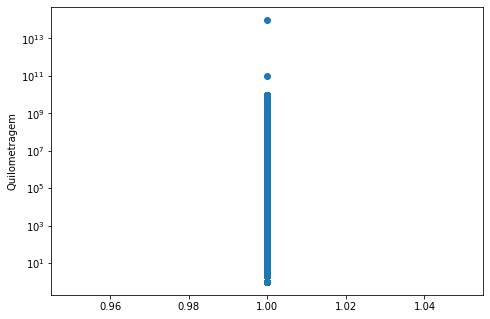

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter([1]*len(df['Quilometragem']), df['Quilometragem'])
ax.set_ylabel('Quilometragem')
ax.set_yscale('log')

<AxesSubplot:ylabel='Frequency'>

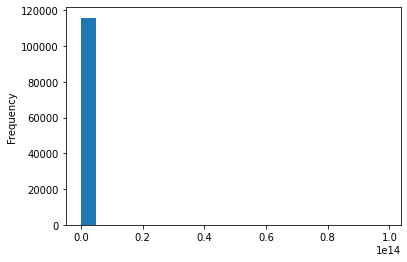

In [55]:
df['Quilometragem'].plot.hist(bins=20)

Existem outliers acima de 300000 km e também existem erros em quilometragens muito baixas como quilometragens que são abaixo de 5000. A baixa quilometragem se refere a anúncios em que a pessoa ao invés de digitar a casa dos milhares, digita apenas o número, por exemplo, para representar 130000km, a pessoa colocar apenas 130. Isso prejudicaria os modelos futuros de machine learning, portanto também serão removidos do dataset. O dataset conterá então apenas carros usados com quilometragem entre 5000km e 300000km.

In [56]:
df = df[df['Quilometragem'] >= 5000]
df = df[df['Quilometragem'] <= 300000]
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa
0,HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4.0,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN
2,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
3,FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2.0,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0
5,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,76812476.0,Porto Velho,Três Marias,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P,FIAT,Hatch,2016,65000.0,1.0,Flex,Manual,Hidráulica,Cinza,4.0,66055490.0,Belém,Umarizal,https://pa.olx.com.br/regiao-de-belem/autos-e-...,3.0
4993,VW - VOLKSWAGEN GOL 1.0 TREND/ POWER 8V 4P,VW - VOLKSWAGEN,Hatch,2012,80000.0,1.0,Flex,Manual,Hidráulica,Prata,4.0,66120000.0,Belém,Sacramenta,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0
4995,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,66123620.0,Belém,Sacramenta,https://pa.olx.com.br/regiao-de-belem/autos-e-...,8.0
4996,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0


<AxesSubplot:ylabel='Frequency'>

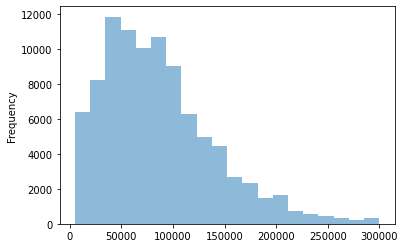

In [57]:
df['Quilometragem'].plot.hist(bins=20, alpha=0.5)

Outra modificação que podemos fazer é analisar a potência do motor que possui valores em uma faixa como mostrado abaixo. Tentaremos minimizar essa quantidade de valores que estão dentro de uma faixa modificando para o valor real da potência do motor do carro.

Para isso, podemos utilizar a coluna 'Modelo' do dataset, em muitos casos os usuários cadastram o carro indicando a potência do motor já no modelo. Portanto, podemos aplicar uma expressão regular para encontrar essa potência e caso não tenha a potência dentro da coluna 'Modelo', utilizaremos a potência fornecida na coluna 'Potência do motor'

In [58]:
item_counts = df["Potência do motor"].value_counts(normalize=True)
item_counts

1.0            0.292323
1.6            0.198407
2.0 - 2.9      0.198369
1.4            0.113257
1.8            0.093190
1.5            0.042352
3.0 - 3.9      0.037829
1.3            0.011747
4.0 ou mais    0.007288
1.7            0.001962
1.2            0.001937
1.9            0.001338
Name: Potência do motor, dtype: float64

In [59]:
import re

def find_motor_potency(row):
    potencies = re.findall('[0-9]\.[0-9]', row['Modelo'])
    
    if len(potencies) == 0:
        return row['Potência do motor']
    
    return potencies[0]

potencies = []
for i, row in tqdm(df.iterrows()):
    potency = find_motor_potency(row)
    potencies.append(potency)
    
df.insert(16, 'motor', potencies)
df

93732it [00:05, 15795.43it/s]


,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa,motor
0,HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4.0,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,2.0
2,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,1.0
3,FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2.0,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0,1.4
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,1.8
5,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,76812476.0,Porto Velho,Três Marias,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P,FIAT,Hatch,2016,65000.0,1.0,Flex,Manual,Hidráulica,Cinza,4.0,66055490.0,Belém,Umarizal,https://pa.olx.com.br/regiao-de-belem/autos-e-...,3.0,1.0
4993,VW - VOLKSWAGEN GOL 1.0 TREND/ POWER 8V 4P,VW - VOLKSWAGEN,Hatch,2012,80000.0,1.0,Flex,Manual,Hidráulica,Prata,4.0,66120000.0,Belém,Sacramenta,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0,1.0
4995,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,66123620.0,Belém,Sacramenta,https://pa.olx.com.br/regiao-de-belem/autos-e-...,8.0,1.0
4996,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0,1.3


In [60]:
item_counts = df["motor"].value_counts(normalize=True)
item_counts

1.0            0.282065
1.6            0.198260
2.0            0.130204
1.4            0.112198
1.8            0.095746
1.5            0.045181
2.8            0.022998
3.0            0.018519
2.5            0.014721
2.4            0.011382
1.3            0.010957
2.0 - 2.9      0.010298
3.2            0.009315
2.2            0.005205
2.7            0.004948
2.3            0.004557
3.5            0.002837
3.6            0.002044
1.2            0.001821
3.0 - 3.9      0.001742
1.7            0.001675
1.1            0.001497
3.9            0.001284
4.1            0.001262
3.3            0.001240
3.8            0.001039
1.9            0.000994
4.0 ou mais    0.000760
4.0            0.000760
4.2            0.000704
6.7            0.000681
4.3            0.000614
6.2            0.000570
4.4            0.000335
5.0            0.000324
3.7            0.000235
5.9            0.000145
4.5            0.000134
4.8            0.000112
3.4            0.000112
4.7            0.000101
5.7            0

In [66]:
df

,Modelo,Marca,Tipo de veículo,Ano,Quilometragem,Potência do motor,Combustível,Câmbio,Direção,Cor,Portas,CEP,Município,Bairro,url,Final de placa,motor
0,HONDA CIVIC SEDAN EX 2.0 FLEX 16V AUT.4P,HONDA,Sedã,2019,15000.0,2.0 - 2.9,Flex,Automático,Elétrica,Preto,4.0,76803750.0,Porto Velho,São João Bosco,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,NaN,2.0
2,VW - VOLKSWAGEN UP! TAKE 1.0 TOTAL FLEX 12V 5P,VW - VOLKSWAGEN,Hatch,2015,100000.0,1.0,Flex,Manual,Hidráulica,Branco,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,1.0
3,FIAT STRADA WORKING 1.4 MPI FIRE FLEX 8V CD,FIAT,Pick-up,2014,90000.0,1.4,Flex,Manual,Hidráulica,Branco,2.0,76924000.0,Nova União,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,3.0,1.4
4,FIAT IDEA ADV.EXT./ADV.EXT. LOC. 1.8 FLEX 5P,FIAT,Hatch,2013,40000.0,1.8,Flex,Automático,Hidráulica,Verde,4.0,76890000.0,Jaru,NaN,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,7.0,1.8
5,FIAT SIENA ELX 1.0 MPI FIRE/FIRE FLEX 8V 4P,FIAT,Passeio,2007,125869.0,1.0,Flex,Manual,Mecânica,Branco,4.0,76812476.0,Porto Velho,Três Marias,https://ro.olx.com.br/rondonia/autos-e-pecas/c...,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,FIAT UNO VIVACE CELEB. 1.0 EVO F.FLEX 8V 5P,FIAT,Hatch,2016,65000.0,1.0,Flex,Manual,Hidráulica,Cinza,4.0,66055490.0,Belém,Umarizal,https://pa.olx.com.br/regiao-de-belem/autos-e-...,3.0,1.0
4993,VW - VOLKSWAGEN GOL 1.0 TREND/ POWER 8V 4P,VW - VOLKSWAGEN,Hatch,2012,80000.0,1.0,Flex,Manual,Hidráulica,Prata,4.0,66120000.0,Belém,Sacramenta,https://pa.olx.com.br/regiao-de-belem/autos-e-...,0.0,1.0
4995,HYUNDAI HB20 COMF./C.PLUS/C.STYLE 1.0 FLEX 12V,HYUNDAI,Passeio,2018,37000.0,NaN,Flex,Manual,NaN,NaN,4.0,66123620.0,Belém,Sacramenta,https://pa.olx.com.br/regiao-de-belem/autos-e-...,8.0,1.0
4996,FIAT UNO WAY 1.3 FLEX 8V 5P,FIAT,Hatch,2019,32900.0,1.3,Flex,Manual,Elétrica,Prata,4.0,67140765.0,Ananindeua,Cidade Nova,https://pa.olx.com.br/regiao-de-belem/autos-e-...,4.0,1.3


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93732 entries, 0 to 4998
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Modelo             93732 non-null  object 
 1   Marca              92873 non-null  object 
 2   Tipo de veículo    81446 non-null  object 
 3   Ano                93732 non-null  object 
 4   Quilometragem      93732 non-null  float64
 5   Potência do motor  78485 non-null  object 
 6   Combustível        90557 non-null  object 
 7   Câmbio             91085 non-null  object 
 8   Direção            79931 non-null  object 
 9   Cor                82753 non-null  object 
 10  Portas             89025 non-null  float64
 11  CEP                93732 non-null  float64
 12  Município          93731 non-null  object 
 13  Bairro             80383 non-null  object 
 14  url                93732 non-null  object 
 15  Final de placa     80648 non-null  float64
 16  motor              8952

In [64]:
df.describe()

,Quilometragem,Portas,CEP,Final de placa
count,93732.000000,89025.000000,9.373200e+04,80648.000000
mean,86087.596125,3.792620,6.110552e+07,4.413972
std,53902.290630,0.609719,2.066812e+07,2.985740
min,5000.000000,2.000000,1.001001e+06,0.000000
25%,45721.500000,4.000000,5.061028e+07,2.000000
50%,78000.000000,4.000000,6.504701e+07,4.000000
75%,115000.000000,4.000000,7.690082e+07,7.000000
max,300000.000000,4.000000,9.998000e+07,9.000000


In [65]:
df.to_csv('cars_dataset.csv', index=False)